In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dim = 12

In [3]:
sentences = [
    "I eat an apple every morning because i am hungry",
    "The bus is very slow and i am late to work",
    "This is a sentence with words",
]
sentences = [sentence.lower() for sentence in sentences]

In [4]:
tokens = {}
for sentence in sentences:
    for word in sentence.split():
        if word not in tokens:
            tokens[word] = len(tokens)
tokens

{'i': 0,
 'eat': 1,
 'an': 2,
 'apple': 3,
 'every': 4,
 'morning': 5,
 'because': 6,
 'am': 7,
 'hungry': 8,
 'the': 9,
 'bus': 10,
 'is': 11,
 'very': 12,
 'slow': 13,
 'and': 14,
 'late': 15,
 'to': 16,
 'work': 17,
 'this': 18,
 'a': 19,
 'sentence': 20,
 'with': 21,
 'words': 22}

In [6]:
token_embeddings = {}
for word in tokens.keys():
    token_embeddings[word] = np.random.rand(dim)

print(f"Embeddings shape: {np.array(list(token_embeddings.values())).shape}")

Embeddings shape: (23, 12)


In [9]:
def get_sentence_embeddings(sentence, embedding_dict):
    words = sentence.split()
    # Paimame įterpinius iš žodyno
    embs = np.array([embedding_dict[word] for word in words if word in embedding_dict])
    return words, embs

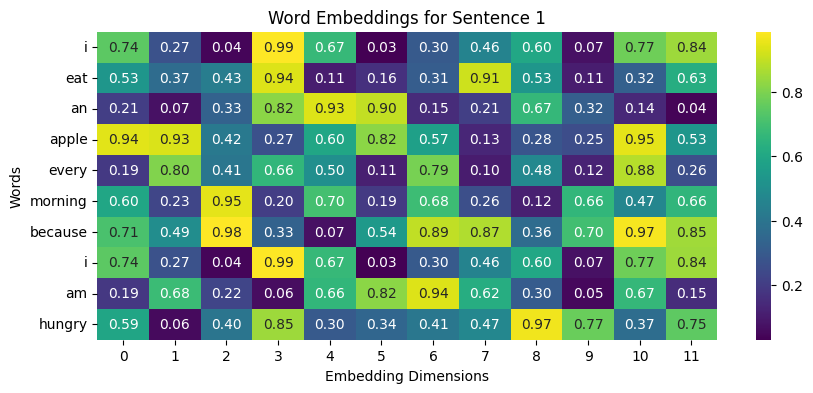

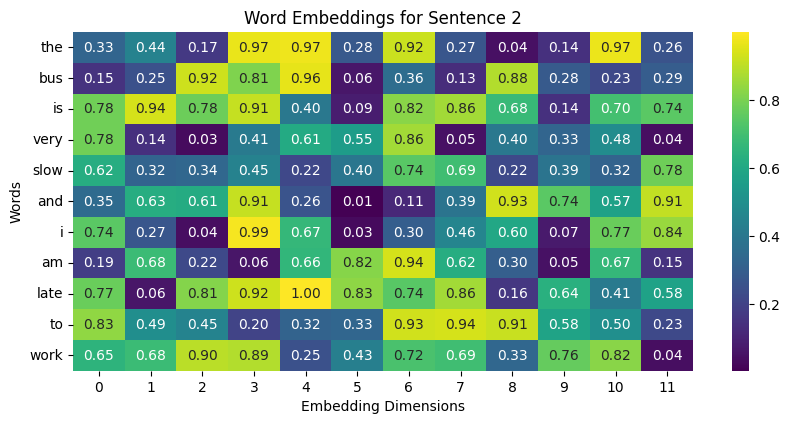

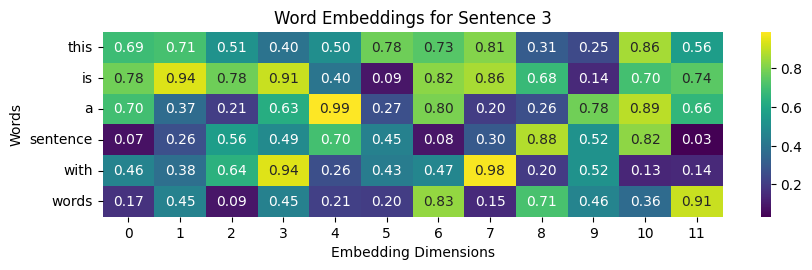

In [13]:
for i, sentence in enumerate(sentences):
    words, embedding_matrix = get_sentence_embeddings(sentence, token_embeddings)

    plt.figure(figsize=(10, len(words) * 0.4))
    sns.heatmap(embedding_matrix, annot=True, fmt=".2f", cmap='viridis', yticklabels=words)
    plt.title(f'Word Embeddings for Sentence {i+1}')
    plt.xlabel('Embedding Dimensions')
    plt.ylabel('Words')
    plt.show()

In [14]:
def xavier_init(fan_in, fan_out):
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_in, fan_out))

In [15]:
def softmax(x):
    e = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e / e.sum(axis=-1, keepdims=True)

In [16]:
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.shape[-1]
    scores = q @ k.T / np.sqrt(d_k)

    if mask is not None:
        scores = scores + mask

    weights = softmax(scores)
    output = weights @ v
    return output, weights

In [17]:
def multi_head_attention(X_query, X_key_val, num_heads, dim, masked=False):
    head_dim = dim // num_heads
    assert head_dim * num_heads == dim, "Dimensija turi dalintis iš galvučių skaičiaus"

    all_weights = []
    outputs = []

    mask = None
    if masked:
        seq_len = X_query.shape[0]
        mask = np.triu(np.ones((seq_len, seq_len)), k=1) * -1e9

    for _ in range(num_heads):
        Wq = xavier_init(dim, head_dim)
        Wk = xavier_init(dim, head_dim)
        Wv = xavier_init(dim, head_dim)

        Q = X_query @ Wq
        K = X_key_val @ Wk
        V = X_key_val @ Wv

        head_out, head_weights = scaled_dot_product_attention(Q, K, V, mask)

        outputs.append(head_out)
        all_weights.append(head_weights)

    final_output = np.concatenate(outputs, axis=-1)

    avg_weights = np.mean(np.array(all_weights), axis=0)

    return final_output, avg_weights

In [18]:
def plot_attention_matrix(weights, x_labels, y_labels, title):
    plt.figure(figsize=(8, 5))
    sns.heatmap(weights, cmap='viridis', annot=True, fmt=".2f",
                xticklabels=x_labels, yticklabels=y_labels)
    plt.title(title)
    plt.xlabel("Keys (Source)")
    plt.ylabel("Queries (Target)")
    plt.show()

--- Self Attention ---


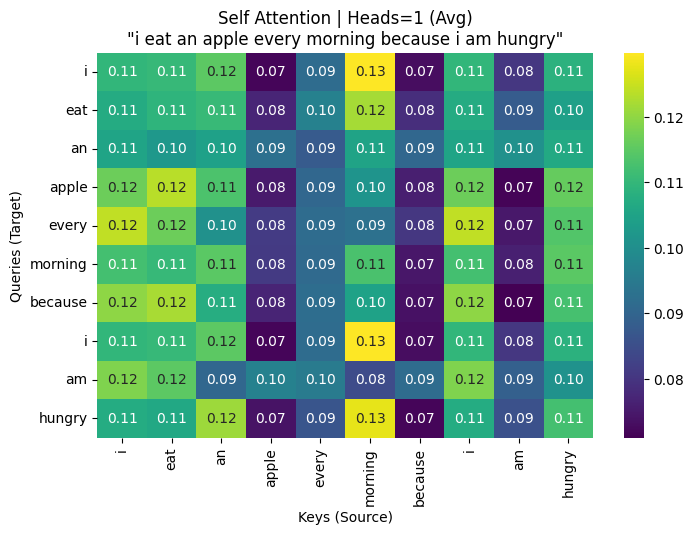

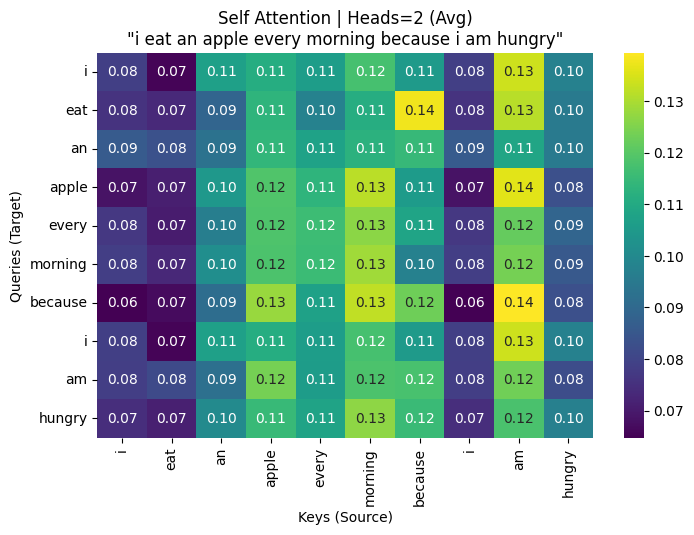

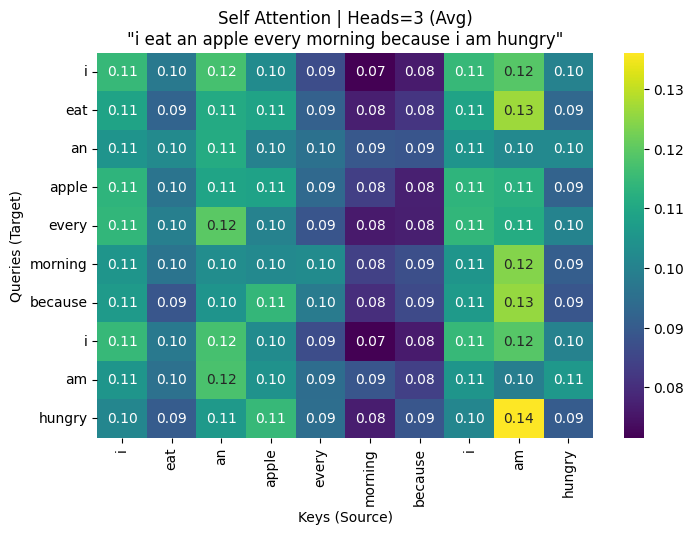

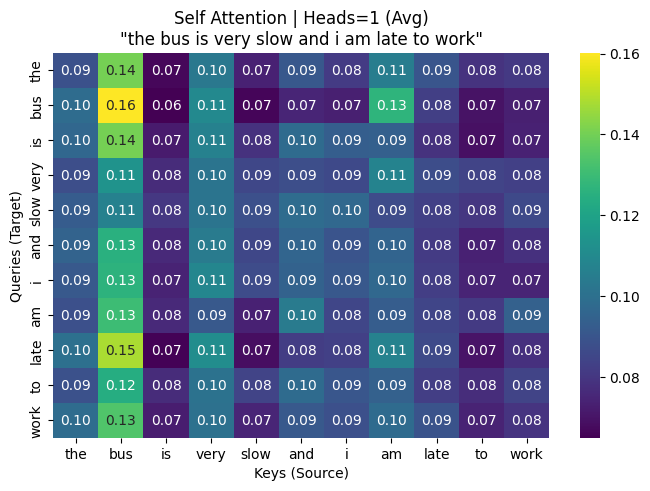

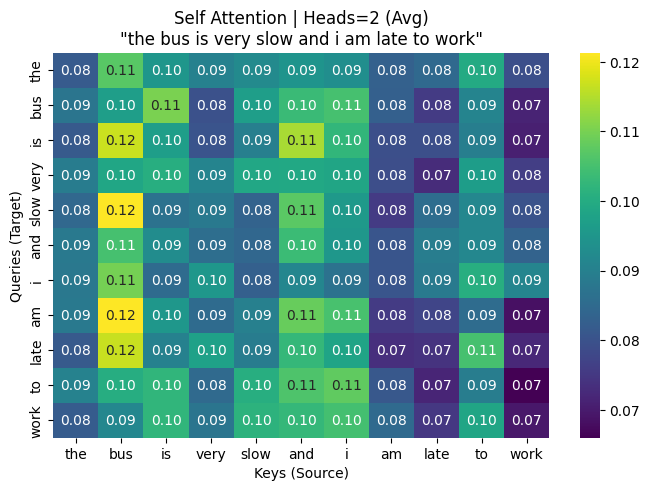

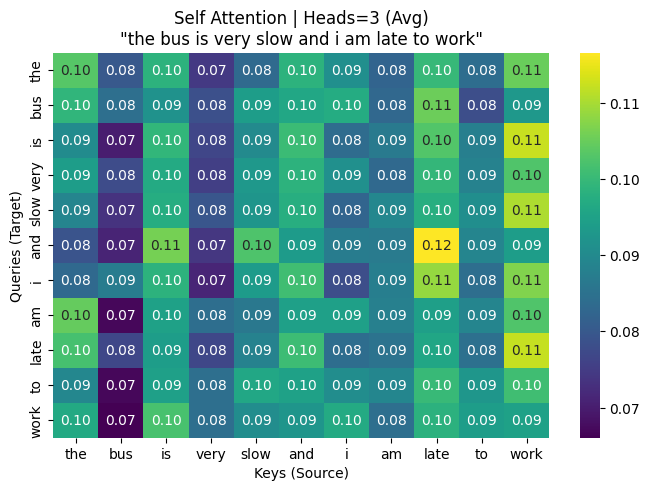

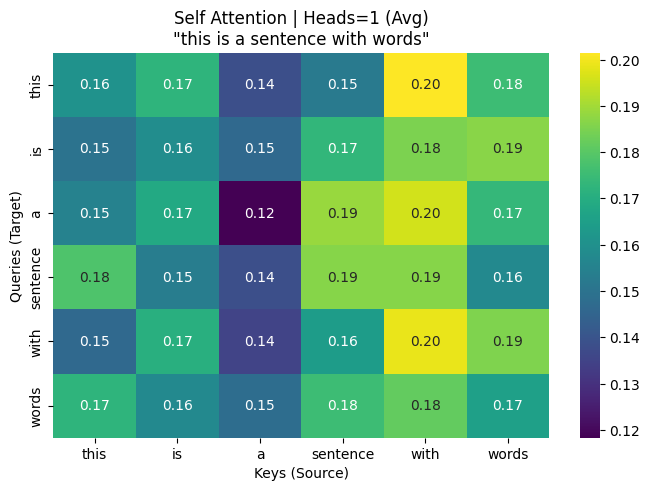

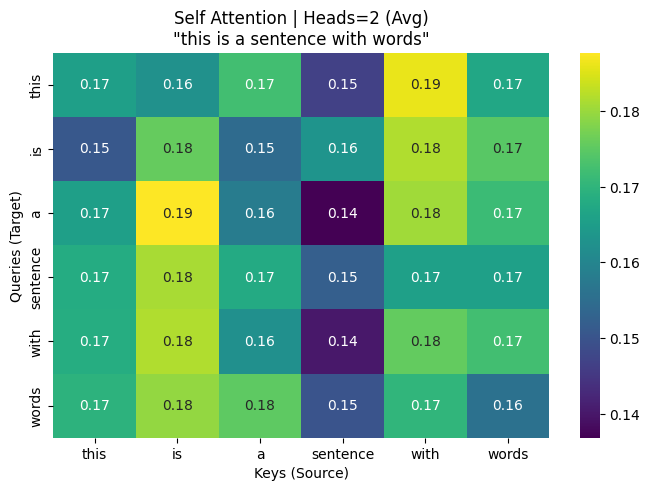

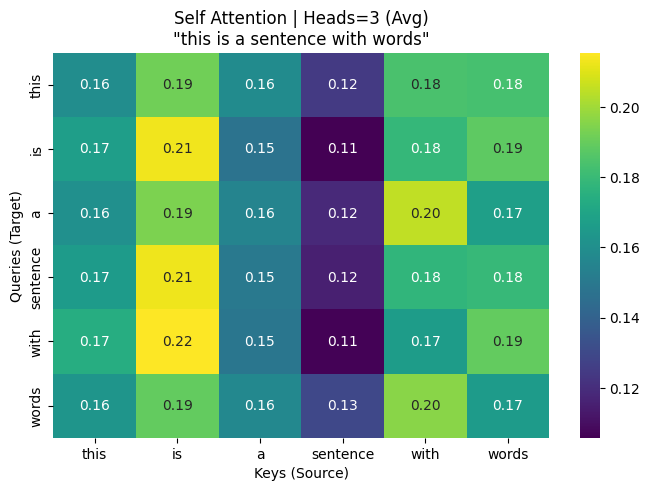

In [19]:
# 1. Self Attention
print("--- Self Attention ---")
for sentence in sentences:
    words, E = get_sentence_embeddings(sentence, token_embeddings)

    for num_heads in range(1, 4):
        # Self attention: Query ir Key/Value yra tas pats sakinys (E)
        output, weights = multi_head_attention(E, E, num_heads, dim, masked=False)

        plot_attention_matrix(
            weights, words, words,
            f"Self Attention | Heads={num_heads} (Avg)\n\"{sentence}\""
        )

--- Masked Self Attention ---


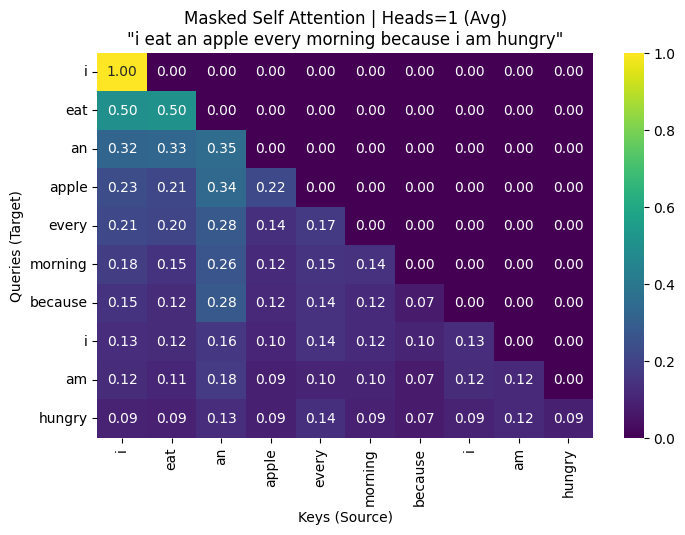

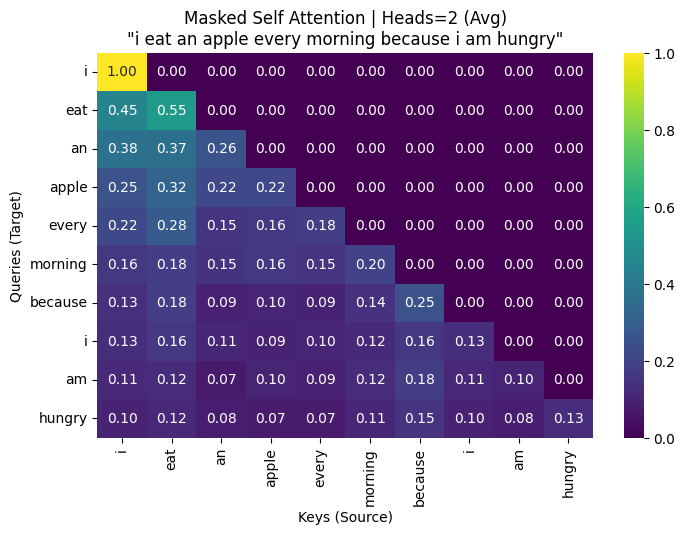

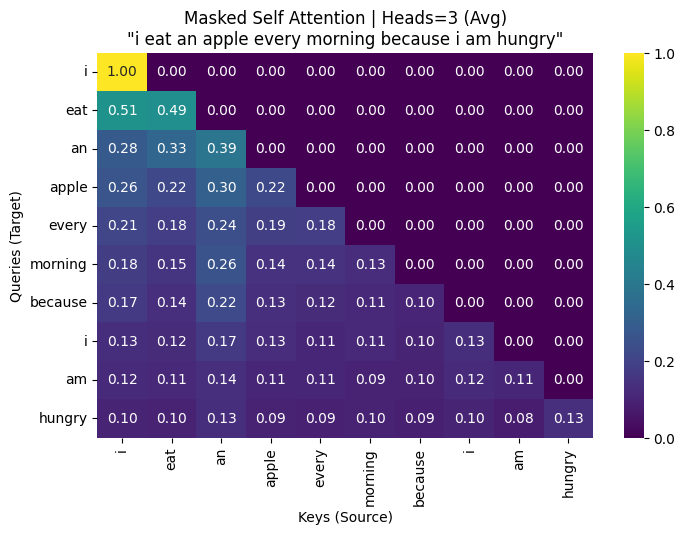

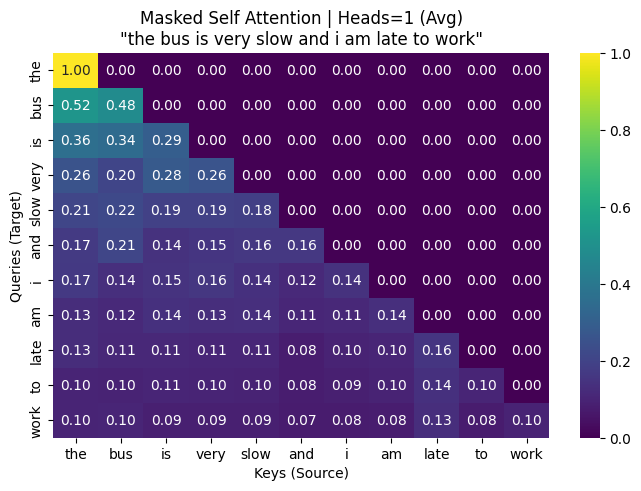

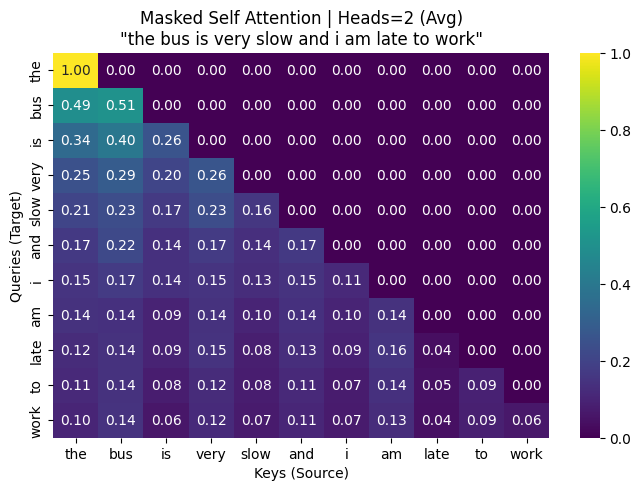

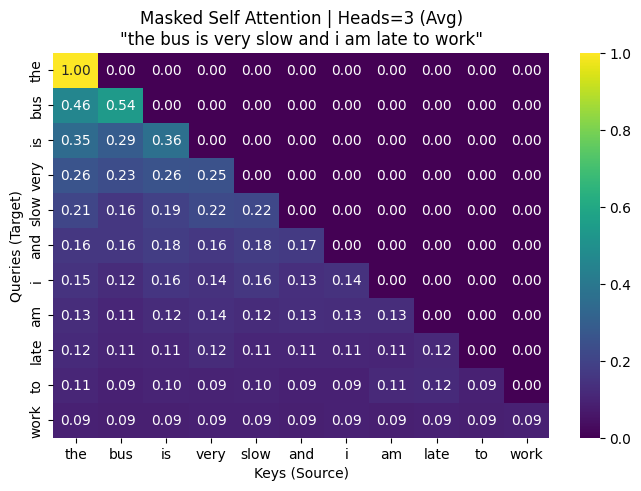

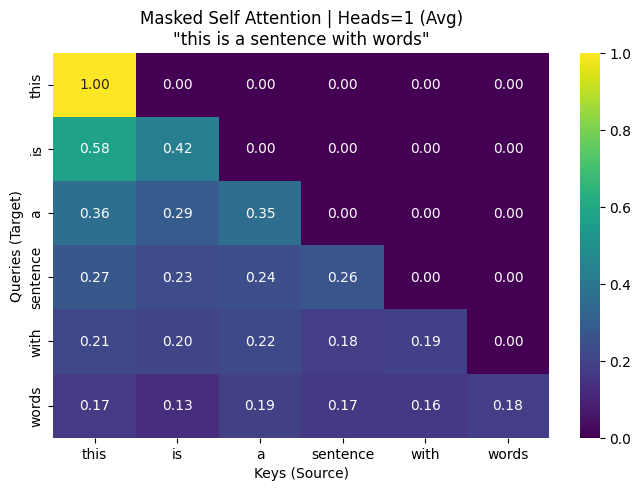

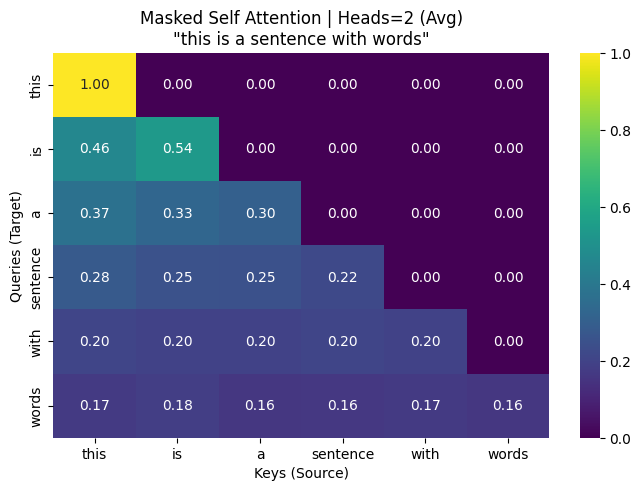

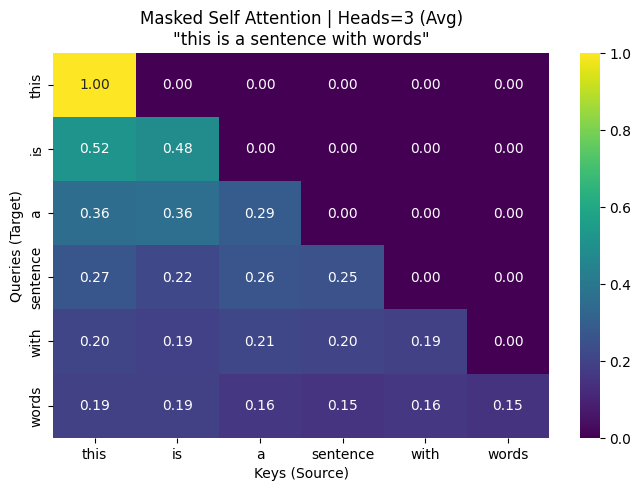

In [20]:
# 2. Masked Self Attention
print("--- Masked Self Attention ---")
for sentence in sentences:
    words, E = get_sentence_embeddings(sentence, token_embeddings)

    for num_heads in range(1, 4):
        output, weights = multi_head_attention(E, E, num_heads, dim, masked=True)

        plot_attention_matrix(
            weights, words, words,
            f"Masked Self Attention | Heads={num_heads} (Avg)\n\"{sentence}\""
        )

--- Cross Attention ---


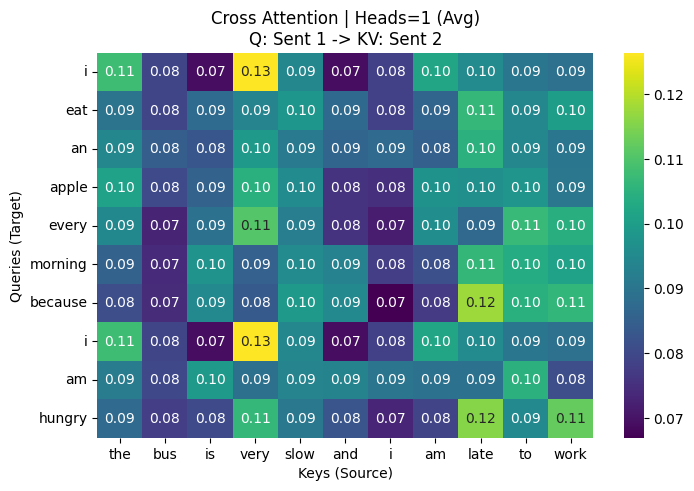

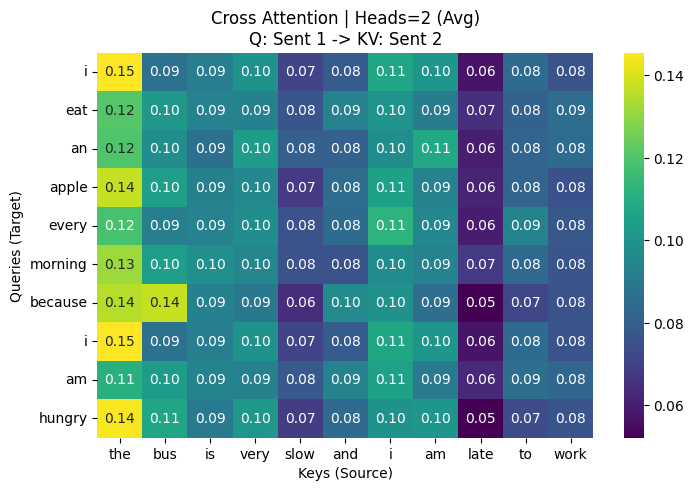

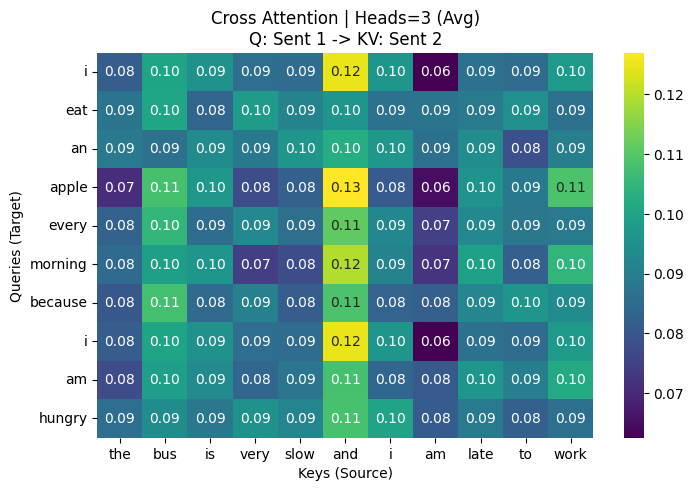

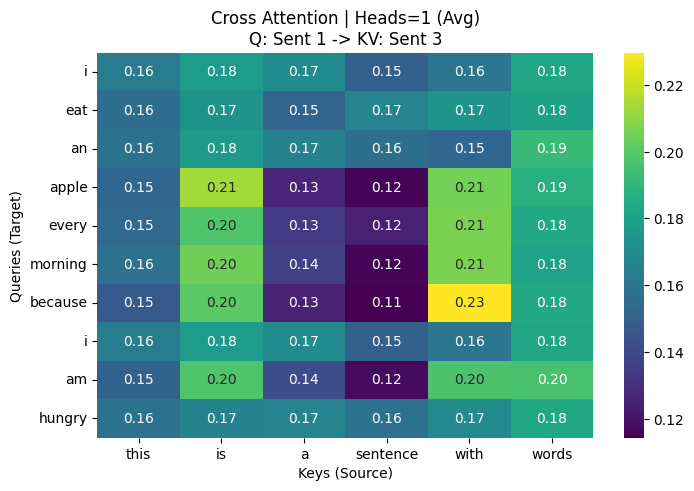

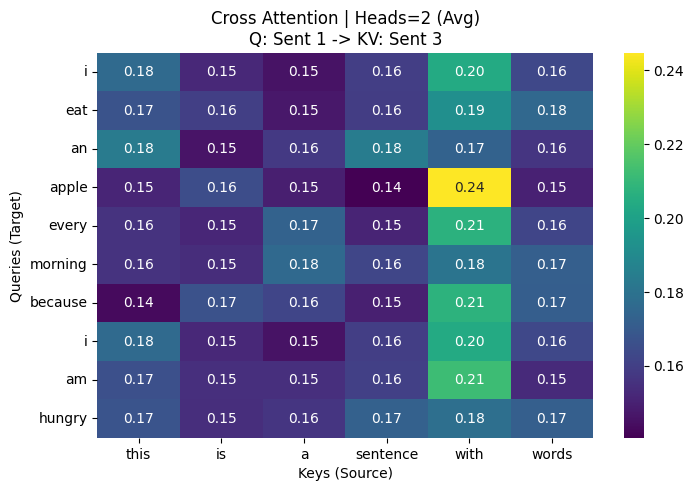

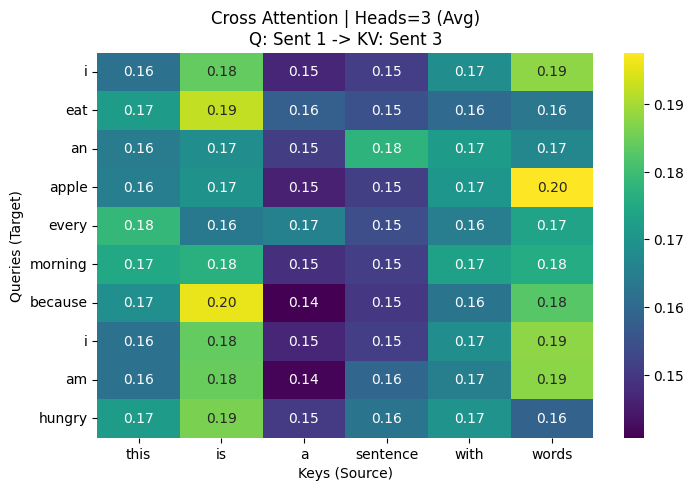

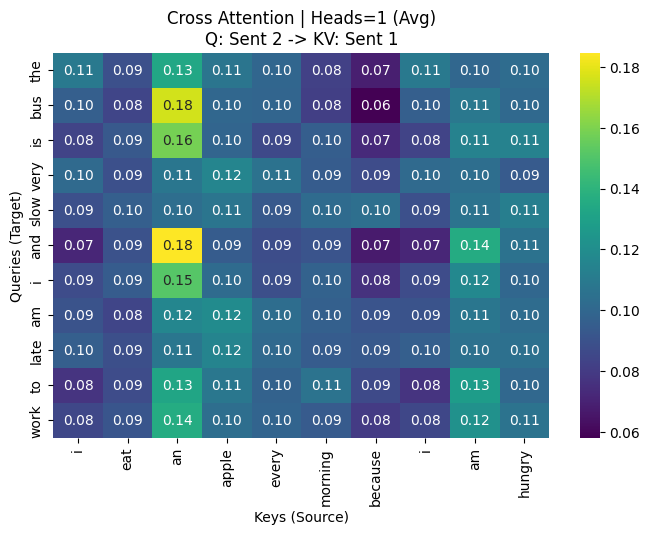

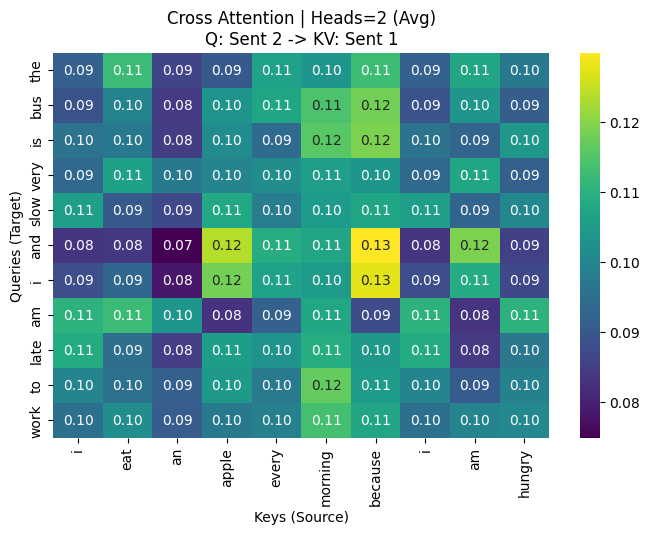

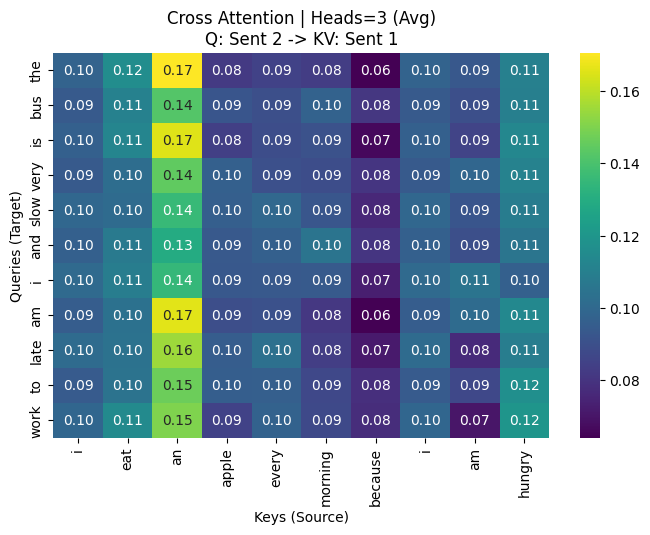

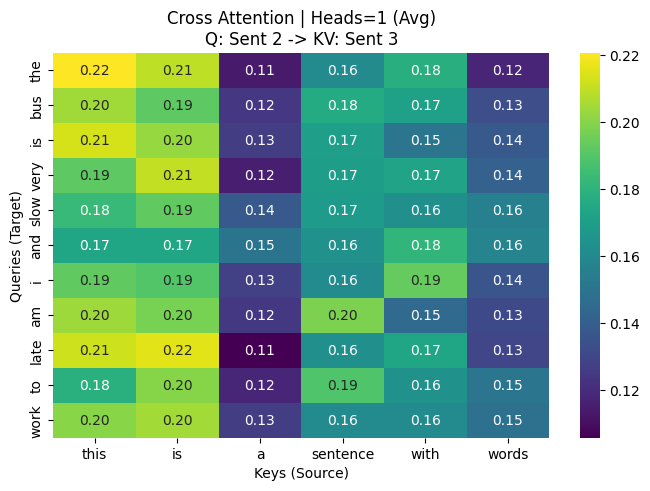

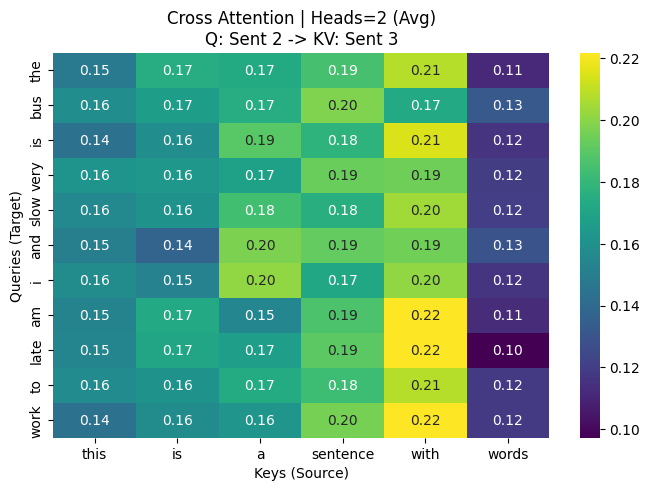

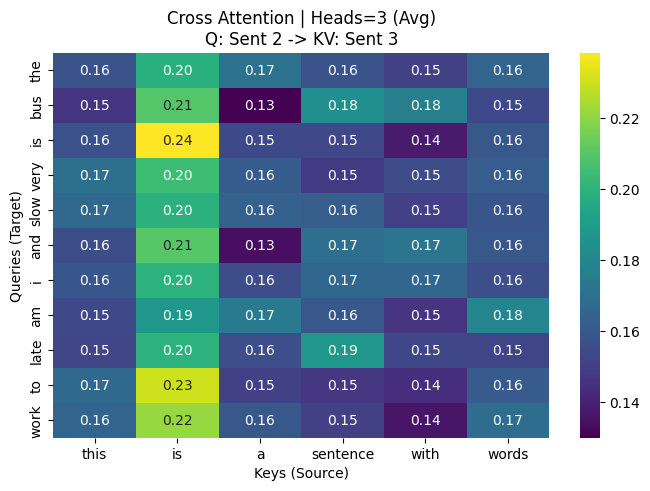

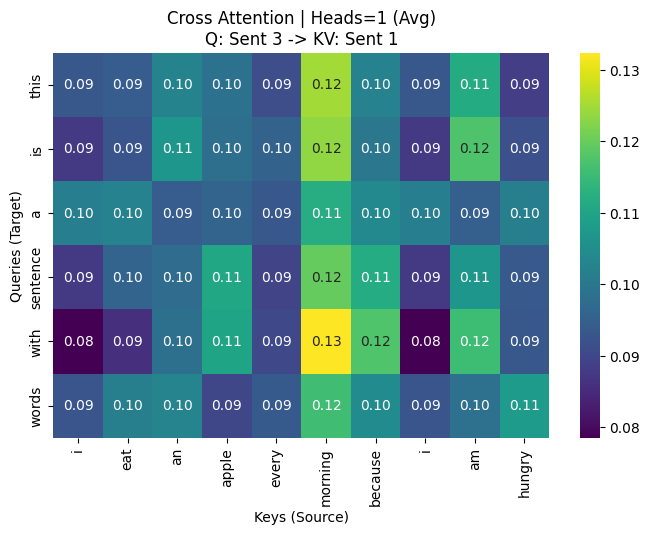

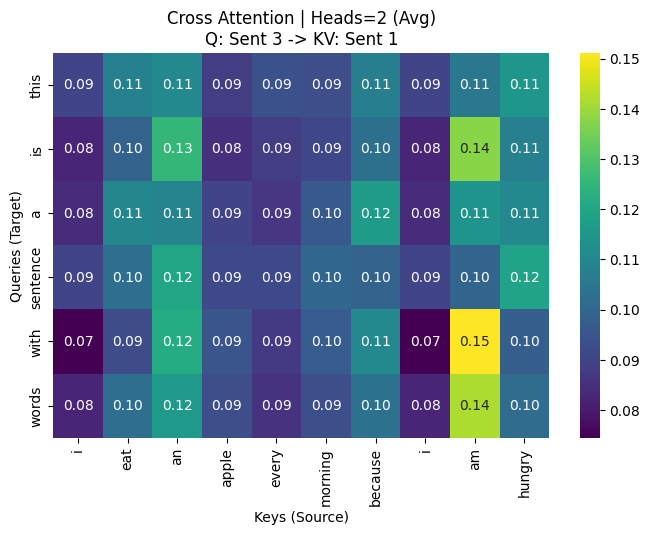

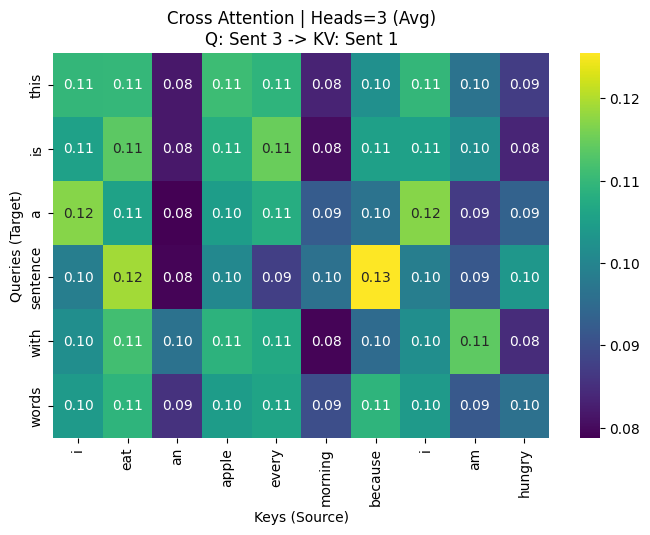

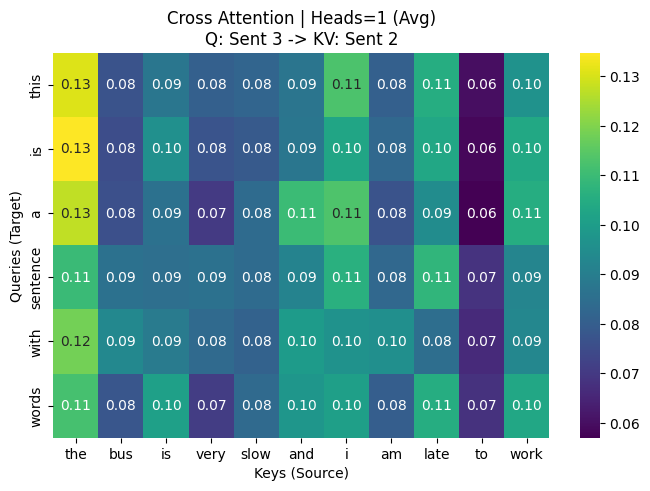

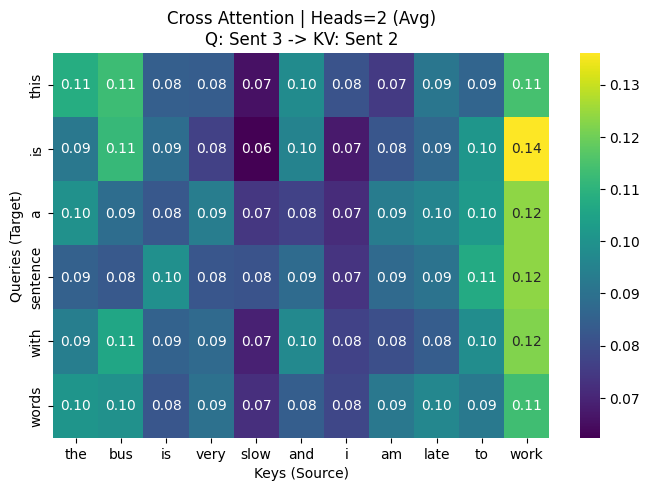

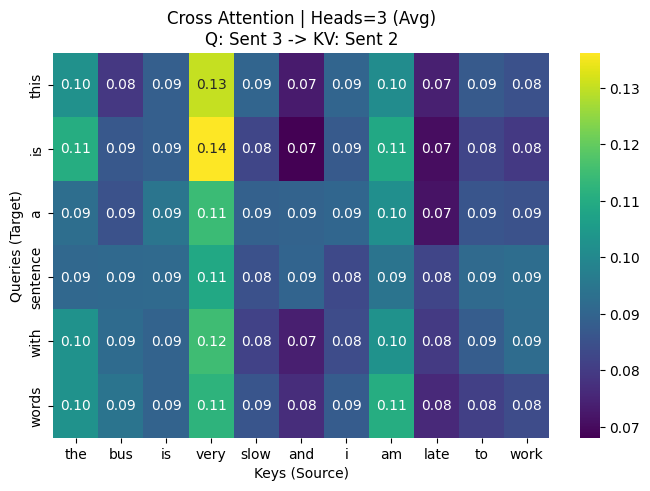

In [22]:
# 3. Cross Attention
print("--- Cross Attention ---")
# Imame poras: sakinys i su sakiniu j
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i == j: continue # Tik skirtingi sakiniai

        words_q, E_q = get_sentence_embeddings(sentences[i], token_embeddings)
        words_kv, E_kv = get_sentence_embeddings(sentences[j], token_embeddings)

        for num_heads in range(1, 4):
            # Cross attention: Query iš pirmo sakinio, Key/Value iš antro
            output, weights = multi_head_attention(E_q, E_kv, num_heads, dim, masked=False)

            plot_attention_matrix(
                weights, words_kv, words_q,
                f"Cross Attention | Heads={num_heads} (Avg)\nQ: Sent {i+1} -> KV: Sent {j+1}"
            )